--- Successfully Parsed F1-Score Results ---
                       Model                        Dataset  F1_Score  \
0    DecisionTree_GridSearch           clean_tokens__(1, 1)    0.7647   
1    DecisionTree_GridSearch           clean_tokens__(2, 2)    0.7442   
2    DecisionTree_GridSearch           clean_tokens__(3, 3)    0.7379   
3    DecisionTree_GridSearch       clean_tokens_ner__(1, 1)    0.7528   
4    DecisionTree_GridSearch       clean_tokens_ner__(2, 2)    0.7236   
..                       ...                            ...       ...   
164     MLP_Classifier_Tuned   snowball_stem_tokens__(1, 1)    0.8647   
165     MLP_Classifier_Tuned   snowball_stem_tokens__(2, 2)    0.8626   
166     MLP_Classifier_Tuned  lancaster_stem_tokens__(1, 1)    0.8726   
167     MLP_Classifier_Tuned  lancaster_stem_tokens__(2, 2)    0.8669   
168     MLP_Classifier_Tuned  lancaster_stem_tokens__(3, 3)    0.7994   

                Token_Type  N_Gram  
0             clean_tokens  (1, 1)  
1   

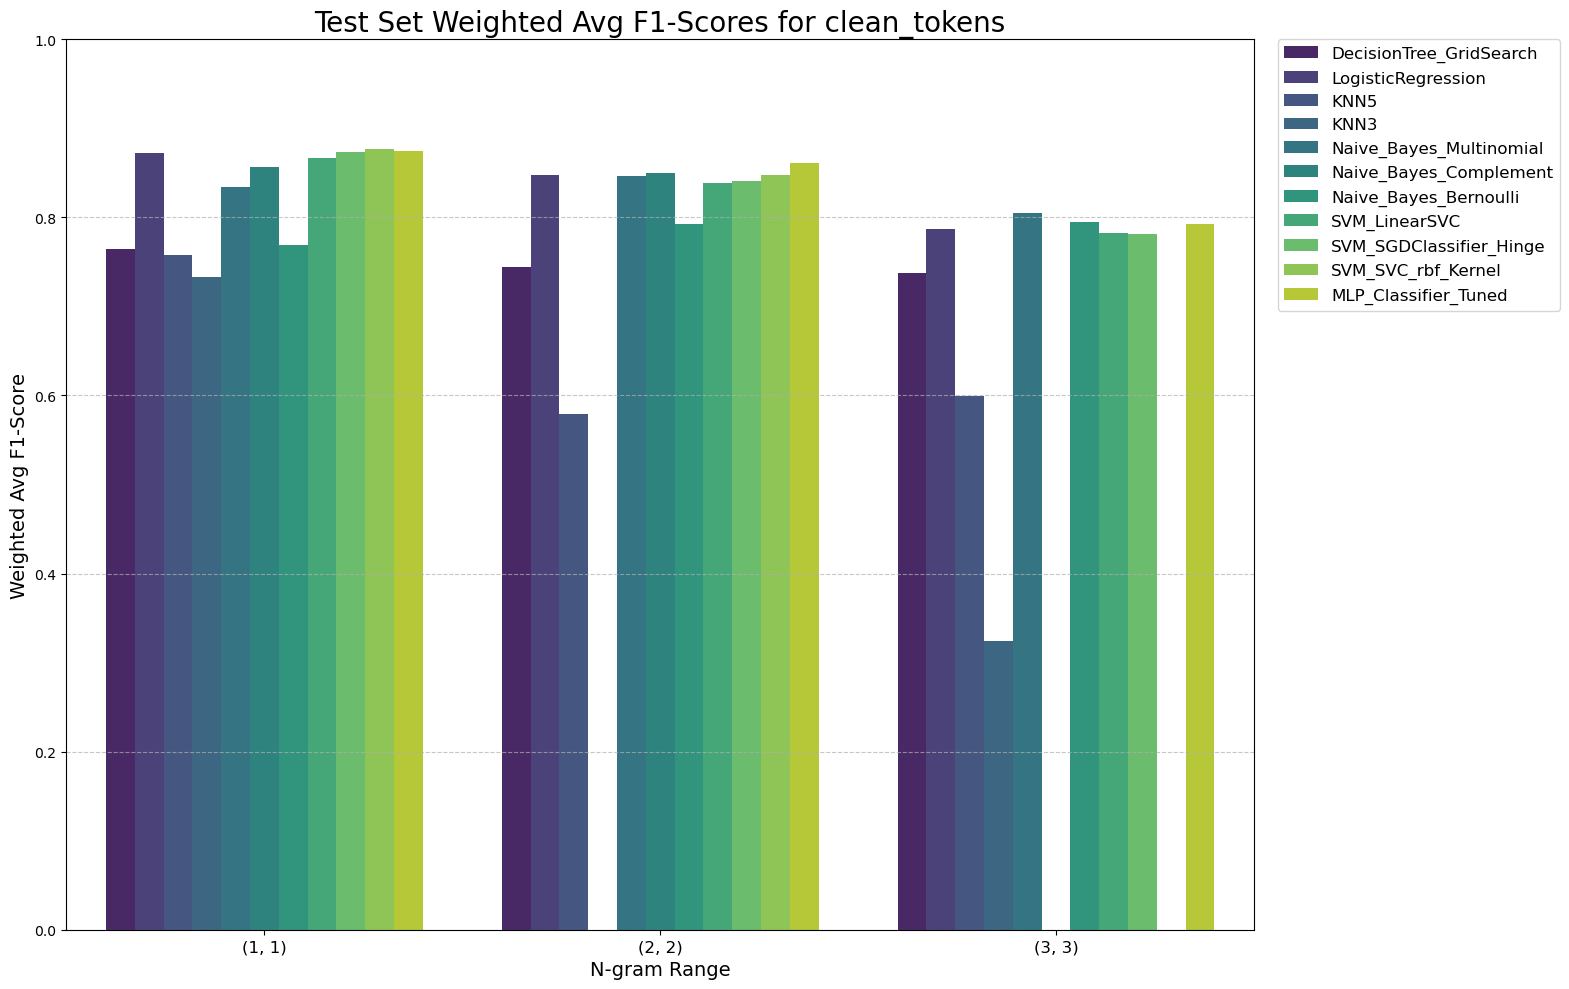


Generating chart for: clean_tokens_ner
Chart successfully saved as f1_score_clean_tokens_ner.png


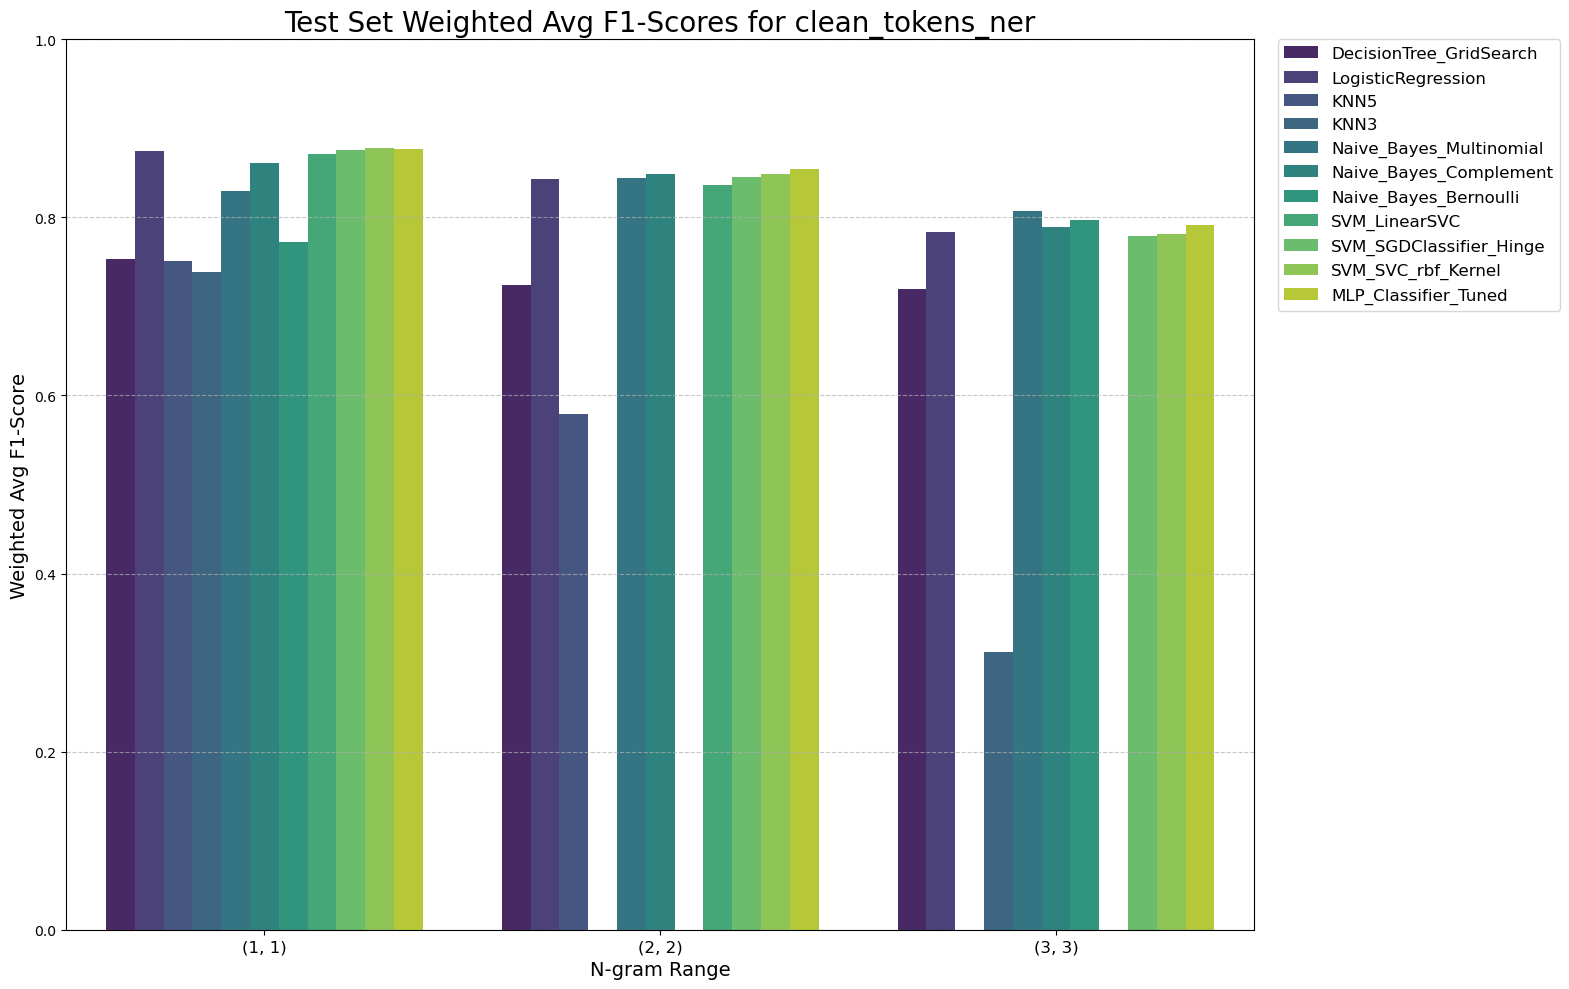


Generating chart for: clean_tokens_pos
Chart successfully saved as f1_score_clean_tokens_pos.png


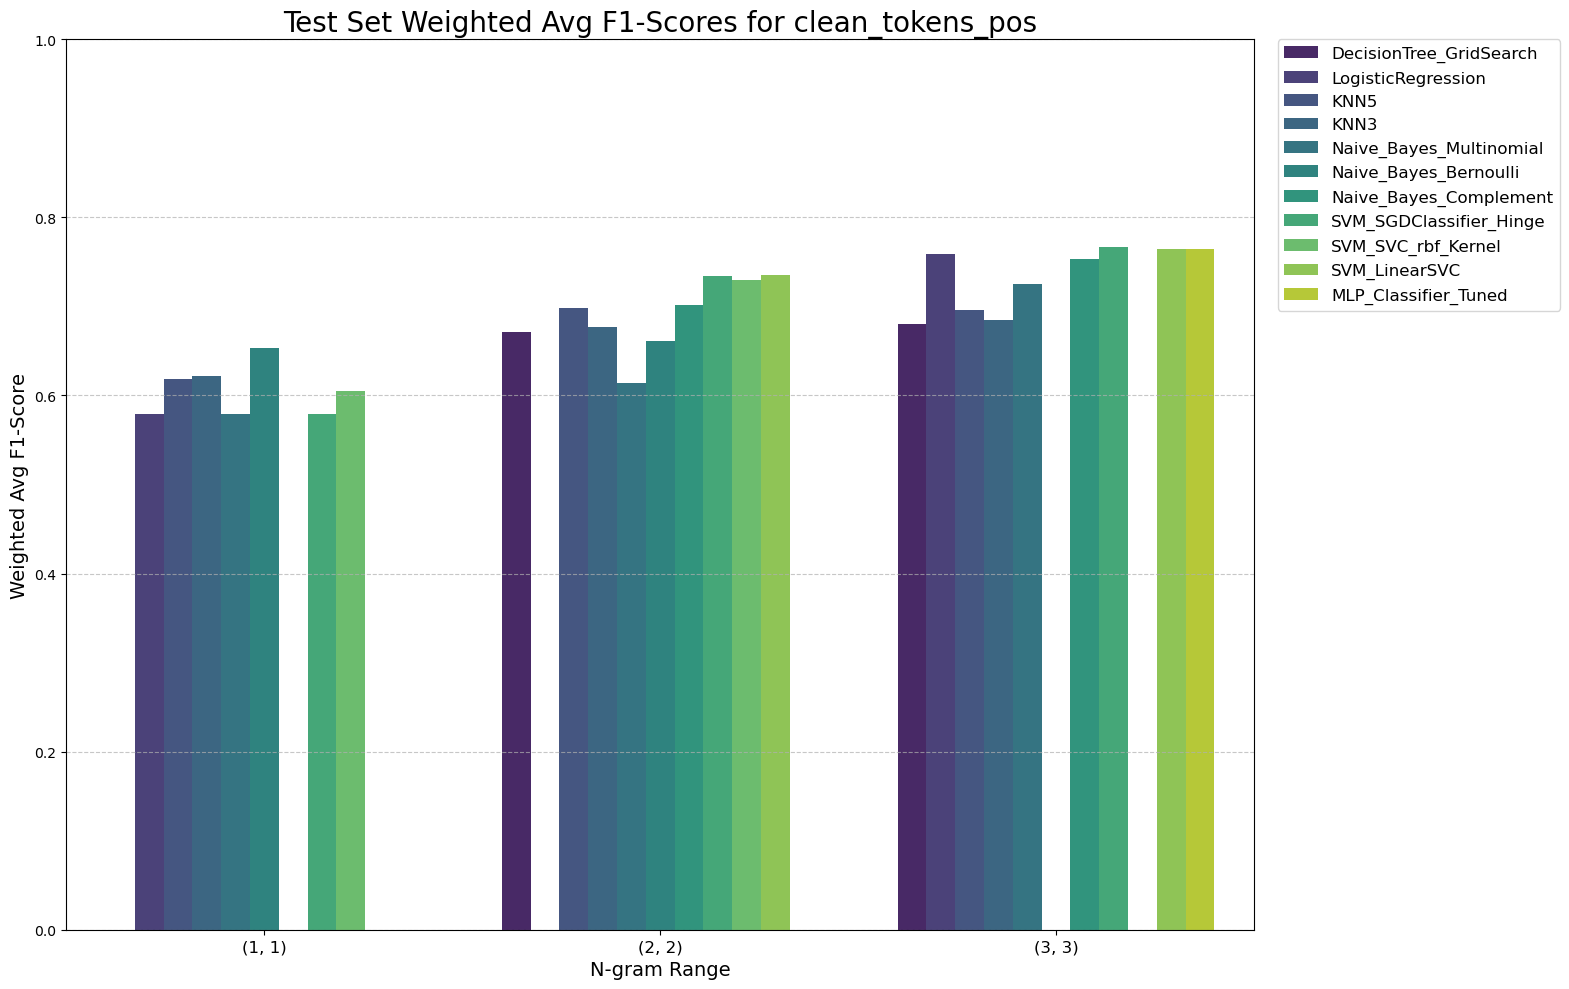


Generating chart for: lancaster_stem_tokens
Chart successfully saved as f1_score_lancaster_stem_tokens.png


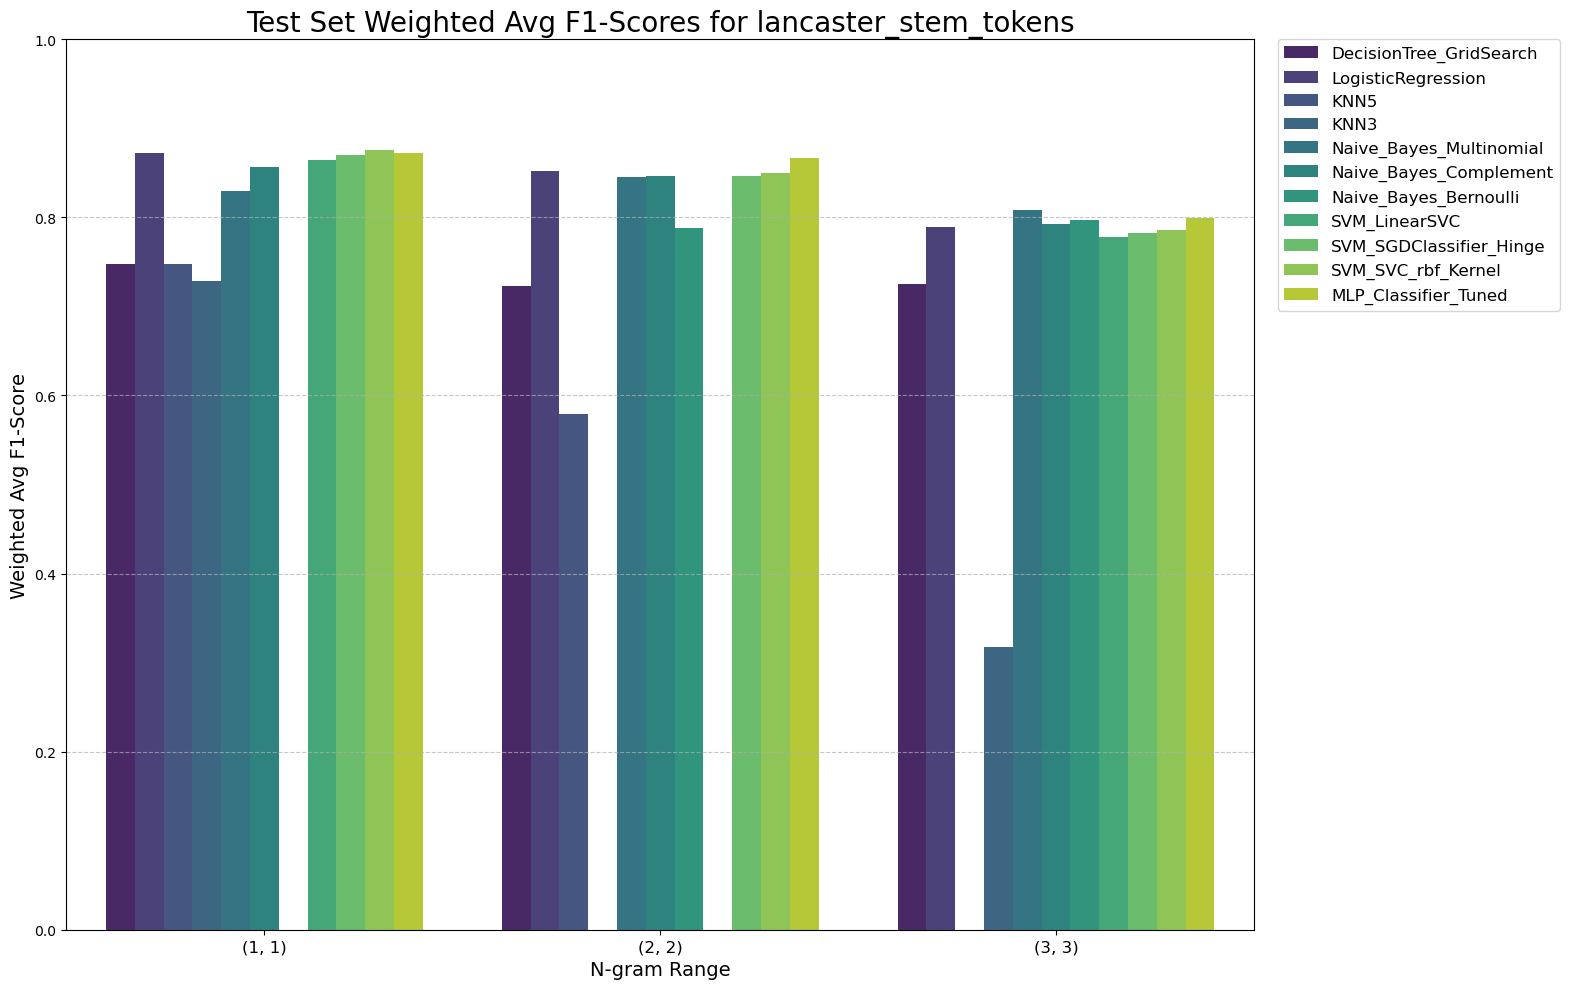


Generating chart for: porter_stem_tokens
Chart successfully saved as f1_score_porter_stem_tokens.png


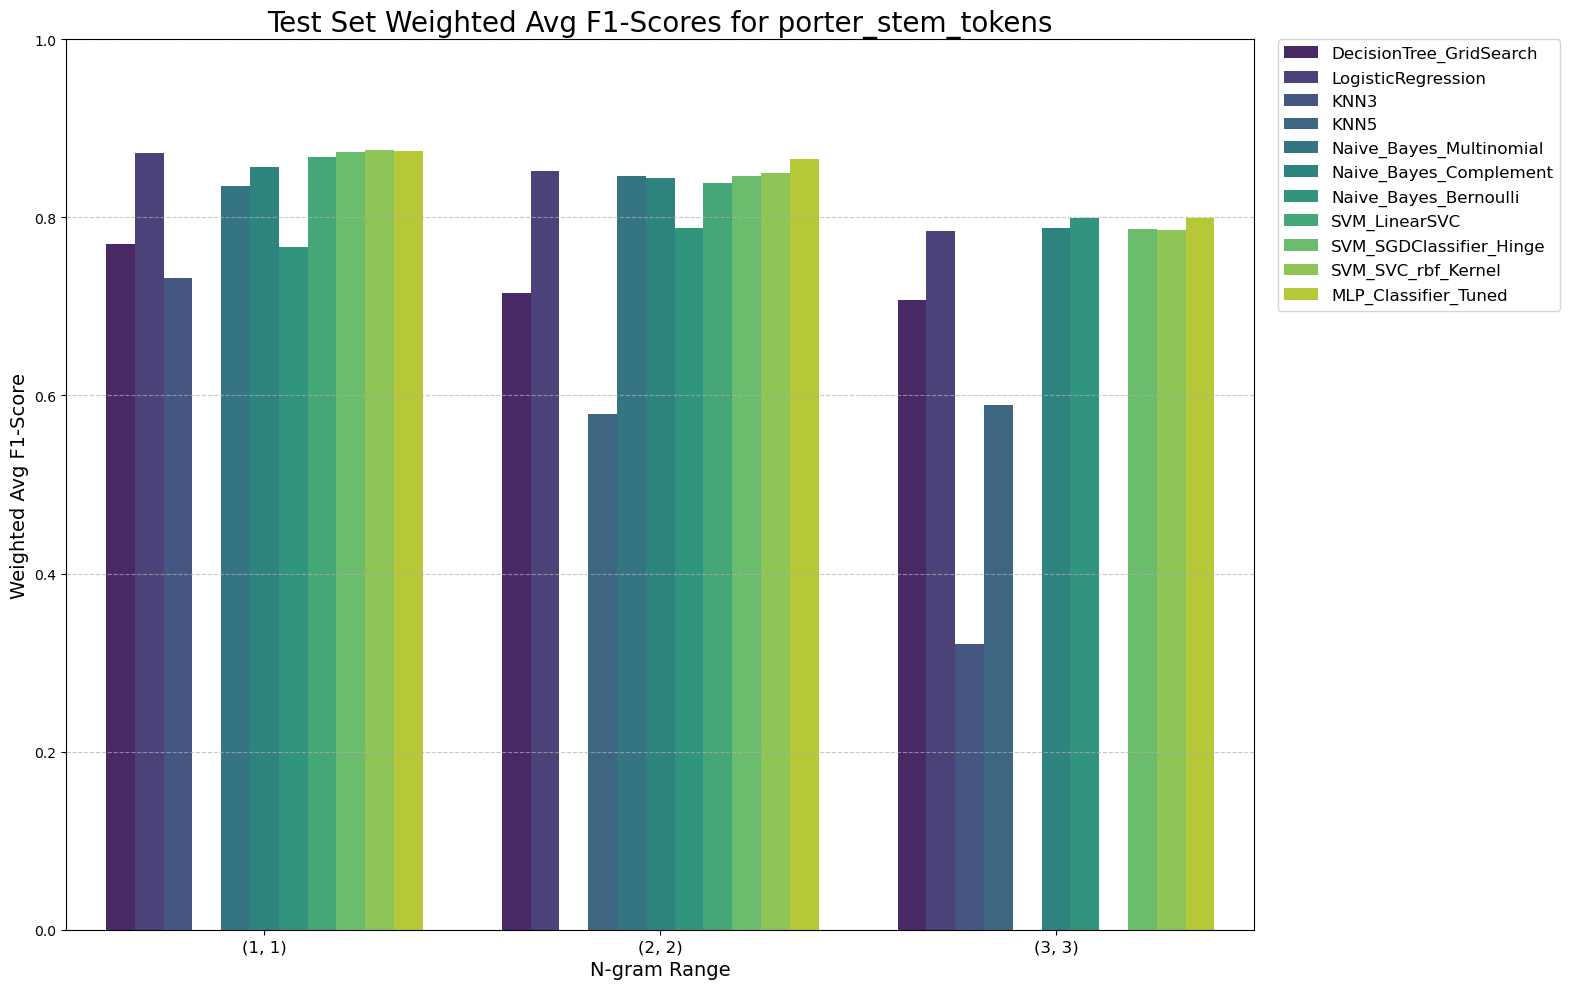


Generating chart for: snowball_stem_tokens
Chart successfully saved as f1_score_snowball_stem_tokens.png


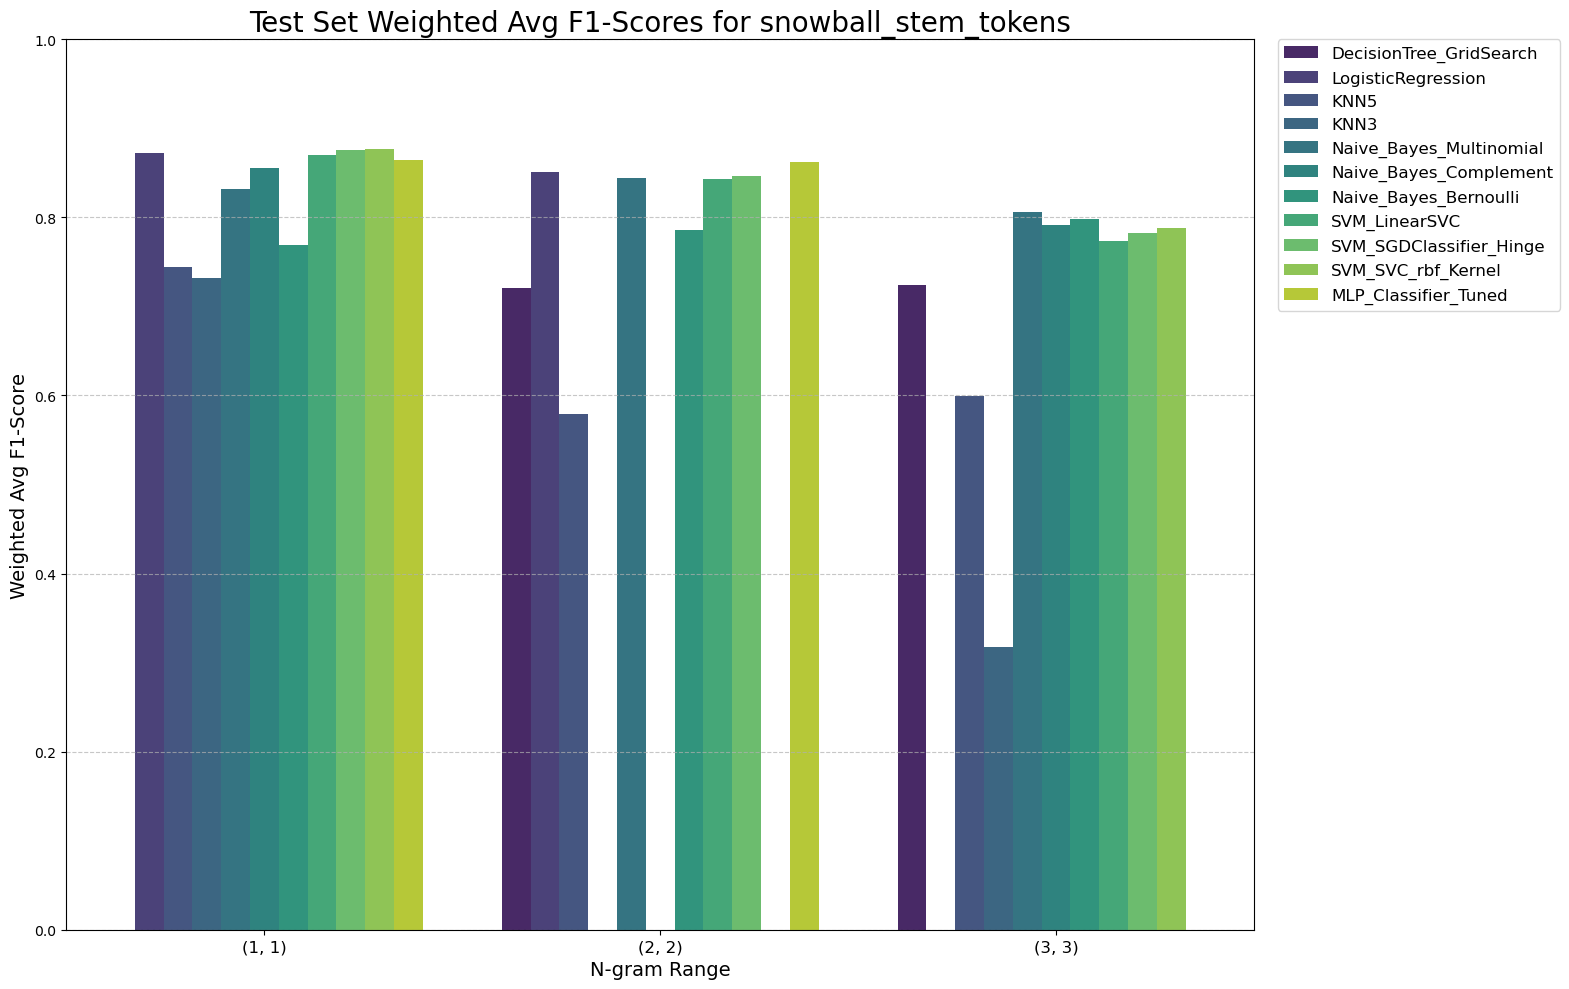

In [3]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Parse the Notebook ---
notebook_path = 'hotels_reviews_model.ipynb'
try:
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
except FileNotFoundError:
    print(f"Error: Could not find the notebook file at '{notebook_path}'")
    notebook = None
except json.JSONDecodeError:
    print(f"Error: Could not parse the JSON in '{notebook_path}'.")
    notebook = None

results = []
if notebook:
    # --- 2. Define Regex Patterns to Find Results ---
    model_dataset_pattern = re.compile(r"MODEL: (.*?)   \|   DATASET: (.*?)\n", re.DOTALL)
    test_report_pattern_grid = re.compile(
        r"--- 2. TEST SET Evaluation ---(.*?)--- 3. GRID SEARCH RESULTS ---", re.DOTALL
    )
    test_report_pattern_no_grid = re.compile(
        r"--- 2. TEST SET Evaluation ---(.*?)Training & Prediction Time:", re.DOTALL
    )
    weighted_avg_pattern = re.compile(
        r"weighted avg\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)\s+(\d+)"
    )

    # --- 3. Iterate Through Cells and Extract Data ---
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code' and 'outputs' in cell:
            for output in cell['outputs']:
                if output['output_type'] == 'stream' and 'text' in output:
                    full_output_text = "".join(output['text'])
                    matches = list(model_dataset_pattern.finditer(full_output_text))
                    
                    for i, match in enumerate(matches):
                        start_index = match.start()
                        end_index = matches[i + 1].start() if (i + 1) < len(matches) else len(full_output_text)
                        block_text = full_output_text[start_index:end_index]
                        
                        model_name = match.group(1).strip()
                        dataset_name = match.group(2).strip()
                        f1_score = None
                        
                        test_report_match = test_report_pattern_grid.search(block_text)
                        if not test_report_match:
                            test_report_match = test_report_pattern_no_grid.search(block_text)
                        
                        if test_report_match:
                            report_text = test_report_match.group(1)
                            weighted_avg_match = weighted_avg_pattern.search(report_text)
                            if weighted_avg_match:
                                f1_score = float(weighted_avg_match.group(3))
                                
                        if f1_score is not None:
                            results.append({
                                'Model': model_name,
                                'Dataset': dataset_name,
                                'F1_Score': f1_score
                            })

# --- 4. Create DataFrame ---
if results:
    df_results = pd.DataFrame(results)
    df_results['F1_Score'] = pd.to_numeric(df_results['F1_Score'])
    
    # --- 5. NEW: Split Dataset into Token_Type and N_Gram ---
    try:
        df_results[['Token_Type', 'N_Gram']] = df_results['Dataset'].str.split('__', expand=True)
    except ValueError as e:
        print(f"Error splitting Dataset column: {e}")
        print("Please ensure your dataset names are in the format 'tokentype__ngram'")
        df_results = None # Stop processing if split failed

if df_results is not None and not df_results.empty:
    print("--- Successfully Parsed F1-Score Results ---")
    print(df_results)
    print("---------------------------------------------")

    # --- 6. MODIFIED: Loop and Plot for Each Token_Type ---
    
    # Get a sorted list of unique token types
    token_types = sorted(df_results['Token_Type'].unique())
    
    for token_type in token_types:
        print(f"\nGenerating chart for: {token_type}")
        
        # Filter the DataFrame for the current token type
        df_subset = df_results[df_results['Token_Type'] == token_type].copy()
        
        # Define the order for the x-axis (n-grams)
        ngram_order = ['(1, 1)', '(2, 2)', '(3, 3)']
        # Filter subset to only include these n-grams and set the order
        df_subset = df_subset[df_subset['N_Gram'].isin(ngram_order)]
        df_subset['N_Gram'] = pd.Categorical(df_subset['N_Gram'], categories=ngram_order, ordered=True)
        
        if df_subset.empty:
            print(f"No data to plot for {token_type}.")
            continue

        # Create the Bar Chart
        plt.figure(figsize=(18, 10)) # Wide figure for model comparison
        sns.barplot(data=df_subset, x='N_Gram', y='F1_Score', hue='Model', palette='viridis')

        plt.title(f'Test Set Weighted Avg F1-Scores for {token_type}', fontsize=20)
        plt.xlabel('N-gram Range', fontsize=14)
        plt.ylabel('Weighted Avg F1-Score', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=10)
        plt.ylim(0, 1.0) # F1-score is between 0 and 1

        # Place legend outside the plot
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)

        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make room for legend
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Save the figure with a unique name
        chart_filename = f'f1_score_{token_type}.png'
        plt.savefig(chart_filename)
        print(f"Chart successfully saved as {chart_filename}")
        plt.show() # Display the plot

else:
    print("No results were found to plot. Please make sure your model training cells have been run and have output.")